# Navy Seal Burpees

## Progress on Track (ano)

### Full Code:
(run)

In [1]:
import os
import shutil
import calendar
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import clear_output

# Definir o ano atual
ano = '2025'

# Definir o diretório do projeto manualmente ou com base no diretório atual
diretorio_projeto = os.getcwd()

# Caminhos relativos
caminho_csv = os.path.join(diretorio_projeto, f'totais_mensais_{ano}.csv')
caminho_backup = os.path.join(diretorio_projeto, '..', '..', 'backup', f'totais_mensais_{ano}_backup.csv')

# Dicionário global para armazenar os totais mensais
totais_mensais = {f'{ano}-{mes:02d}': 0 for mes in range(1, 13)}


def criar_df_mensal(mes, ano):
    """
    Cria um DataFrame para o mês e ano fornecidos.
    """
    num_dias = calendar.monthrange(int(ano), mes)[1]
    dias = pd.date_range(start=f'{ano}-{mes:02d}-01', periods=num_dias, freq='D')
    return pd.DataFrame(index=dias, columns=['NSB'])


def coletar_dados(mes, ano):
    """
    Coleta dados de NSB para o mês e ano fornecidos, exibindo os valores já existentes (se houver).
    """
    df = criar_df_mensal(mes, ano)
    num_dias = len(df)
    
    # Carregar os dados existentes do arquivo CSV diário
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    if os.path.exists(caminho_arquivo):
        df_existente = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
        df_existente_mes = df_existente[df_existente.index.month == mes]
        for dia in range(1, num_dias + 1):
            data_dia = f'{ano}-{mes:02d}-{dia:02d}'
            if data_dia in df_existente_mes.index.strftime('%Y-%m-%d').to_list():
                df.at[pd.Timestamp(data_dia), 'NSB'] = df_existente_mes.at[pd.Timestamp(data_dia), 'NSB']

    dados_nsbs = []

    for dia in range(1, num_dias + 1):
        while True:
            try:
                data_dia = f'{ano}-{mes:02d}-{dia:02d}'
                valor_existente = df.at[pd.Timestamp(data_dia), 'NSB']
                if pd.isna(valor_existente):
                    valor_existente = 0
                sugestao = f"[Atual: {valor_existente}]" if valor_existente else ""
                
                valor = input(f"Digite o número de NSBs para o dia {dia} {sugestao} (ou pressione Enter para manter {valor_existente}): ").strip()
                if valor == '':
                    valor = valor_existente
                else:
                    valor = int(valor)
                if valor < 0:
                    raise ValueError("O valor não pode ser negativo.")
                dados_nsbs.append(valor)
                break
            except ValueError as e:
                print(f"Entrada inválida. {e}. Por favor, digite um número inteiro não negativo.")
    
    return df, dados_nsbs


def revisar_dados(df, dados_nsbs):
    """
    Permite ao usuário revisar e corrigir os dados inseridos.
    """
    while True:
        revisar_dados = input("Deseja alterar algum valor? [s/n] (Pressione Enter para continuar): ").strip().lower()
        
        if revisar_dados == 's':
            print("\nDados Inseridos:")
            for dia, valor in enumerate(dados_nsbs, start=1):
                print(f"Dia {dia}: {valor}")
            
            while True:
                try:
                    revisar_dia = input("\nDigite o número do dia para corrigir (ou pressione Enter para continuar): ").strip()
                    if revisar_dia == '':
                        break
                    dia_corrigir = int(revisar_dia)
                    if 1 <= dia_corrigir <= len(dados_nsbs):
                        novo_valor = input(f"Digite o novo número de NSBs para o dia {dia_corrigir}: ").strip()
                        if novo_valor == '':
                            novo_valor = dados_nsbs[dia_corrigir - 1]
                        else:
                            novo_valor = int(novo_valor)
                        if novo_valor < 0:
                            raise ValueError("O valor não pode ser negativo.")
                        dados_nsbs[dia_corrigir - 1] = novo_valor
                        df['NSB'] = dados_nsbs
                    else:
                        print("Número do dia inválido.")
                except ValueError as e:
                    print(f"Entrada inválida. {e}. Por favor, digite um número inteiro.")
        elif revisar_dados == '' or revisar_dados == 'n':
            break
        else:
            print("Resposta inválida. Por favor, digite 's' para sim ou pressione Enter para continuar.")


def adicionar_dados_e_plotar(mes, ano):
    """
    Adiciona os dados de NSB ao DataFrame e gera um gráfico.
    """
    df, dados_nsbs = coletar_dados(mes, ano)
    df['NSB'] = dados_nsbs
    revisar_dados(df, dados_nsbs)
    
    total_nsb_mes = df['NSB'].sum()
    
    # Limpar a saída anterior
    clear_output(wait=True)
    
    # Definir colormap
    cmap = plt.get_cmap('nipy_spectral')

    norm = Normalize(vmin=0, vmax=550)
    colors = cmap(norm(df['NSB']))
    
    plt.figure(figsize=(14, 7))
    plt.bar(df.index.strftime('%d/%b'), df['NSB'], color=colors)
    plt.title(f'{mes:02d}/{ano} - Total NSB: {total_nsb_mes}', fontsize=16, weight='bold')
    plt.xlabel('Dia/Mês', fontsize=14)
    plt.ylabel('Navy Seal Burpees', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    
    plt.show()
    
    # Atualizar totais mensais
    chave = f'{ano}-{mes:02d}'
    totais_mensais[chave] = total_nsb_mes

    # Salvar o CSV atualizado
    salvar_totais_csv(caminho_csv, totais_mensais)

    # Fazer backup do CSV
    fazer_backup_csv(caminho_csv, caminho_backup)
    
    # Preparar dados diários para salvar
    df_diario = criar_df_mensal(mes, ano)
    df_diario['NSB'] = dados_nsbs
    
    # Adicionar coluna 'Data' ao DataFrame
    df_diario.reset_index(inplace=True)
    df_diario.rename(columns={'index': 'Data'}, inplace=True)
    
    # Salvar os dados diários automaticamente
    salvar_dados_diarios_csv(df_diario, mes, ano)

    # Atualizar o arquivo de frequência automaticamente
    atualizar_frequencia(ano)


def salvar_totais_csv(caminho, totais):
    """
    Salva os totais mensais em um arquivo CSV.
    """
    df_totais = pd.DataFrame(list(totais.items()), columns=['Mes', 'Total'])
    os.makedirs(os.path.dirname(caminho), exist_ok=True)  # Certifica-se de que o diretório existe
    df_totais.to_csv(caminho, index=False)


def fazer_backup_csv(caminho_origem, caminho_destino):
    """
    Faz uma cópia de backup do arquivo CSV.
    """
    os.makedirs(os.path.dirname(caminho_destino), exist_ok=True)  # Certifica-se de que o diretório existe
    shutil.copyfile(caminho_origem, caminho_destino)


def salvar_dados_diarios_csv(df, mes, ano):
    # Nome do arquivo com base no ano
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)

    # Garantir que o DataFrame contém a coluna 'Data' e a coluna 'NSB'
    if 'Data' not in df.columns:
        raise ValueError("O DataFrame fornecido deve conter a coluna 'Data'.")
    if 'NSB' not in df.columns:
        raise ValueError("O DataFrame fornecido deve conter a coluna 'NSB'.")

    # Criar um DataFrame com todos os dias do ano se o arquivo não existir
    if not os.path.exists(caminho_arquivo):
        datas = pd.date_range(start=f'{ano}-01-01', end=f'{ano}-12-31', freq='D')
        df_completo = pd.DataFrame({'Data': datas, 'NSB': 0})
        df_completo.set_index('Data', inplace=True)
        df_completo.to_csv(caminho_arquivo)

    # Carregar os dados existentes
    df_existente = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')

    # Configurar o índice do DataFrame fornecido como 'Data'
    df.set_index('Data', inplace=True)

    # Atualizar os dados existentes com os novos valores
    df_existente.update(df)

    # Salvar o DataFrame atualizado em CSV
    df_existente.to_csv(caminho_arquivo, index_label='Data', columns=['NSB'])


def carregar_totais_csv(caminho):
    """
    Carrega os totais mensais de um arquivo CSV, se existir.
    """
    if os.path.exists(caminho):
        df_totais = pd.read_csv(caminho)
        totais = df_totais.set_index('Mes')['Total'].to_dict()
        return totais
    else:
        return None

# Carregar totais do CSV ao iniciar
totais_carregados = carregar_totais_csv(caminho_csv)
if totais_carregados:
    totais_mensais.update(totais_carregados)


def calcular_totais_mensais():
    """
    Retorna um dicionário com o total de NSBs para cada mês.
    """
    return totais_mensais



def print_totais_mensais():
    totais = calcular_totais_mensais()
    output_str = "    "
    for count, (mes, total) in enumerate(totais.items(), 1):
        output_str += f"'{mes}': {total}, "
        if count % 6 == 0 and count != len(totais):
            output_str = output_str.rstrip(", ") + ",\n    "
    output_str = output_str.rstrip(", ") + ","
    print(output_str)

# print_totais_mensais()


def plotar_grafico_total(anos=None):
    if anos == ["todos"]:
        anos = sorted({mes[:4] for mes in totais_mensais.keys()}, reverse=True)
    
    meses = [f'{mes:02d}' for mes in range(1, 13)]
    plt.figure(figsize=(12, 6))
    
    for ano in anos:
        totais_ano = [totais_mensais.get(f'{ano}-{mes}', 0) for mes in meses]
        total_ano = sum(totais_ano)
        plt.plot(meses, totais_ano, marker='o', label=f'{ano} ({total_ano})', linewidth=2, markersize=6)
        
        for mes, total in zip(meses, totais_ano):
            plt.text(mes, total, f'{total}', ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Navy Seal Burpees - {ano}', fontsize=16, weight='bold')
    plt.xlabel('Mês', fontsize=14)
    plt.legend(title='', fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()


def contar_frequencia(ano):
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    
    if not os.path.exists(caminho_arquivo):
        print(f"O arquivo {nome_arquivo} não foi encontrado.")
        return
    
    # Carregar os dados do CSV diário
    df = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
    
    # Contar a frequência de cada quantidade de NSBs
    frequencia = df['NSB'].value_counts().sort_index()

    # Filtrar quantidades diferentes de zero para o cálculo de porcentagens
    frequencia_sem_zero = frequencia[frequencia.index != 0]

    # Calcular o total geral para todas as quantidades, incluindo zero
    total_geral = frequencia.sum()

    # Calcular o total apenas para quantidades não-zero
    total_sem_zero = frequencia_sem_zero.sum()

    # Calcular a porcentagem para a quantidade 0 sobre o total geral
    porcentagem_zero = (frequencia[0] / total_geral) * 100 if 0 in frequencia.index else 0

    # Calcular a porcentagem para as quantidades não-zero
    porcentagem_nao_zero = (frequencia_sem_zero / total_sem_zero) * 100

    # Converter a Series para um DataFrame para manter os nomes das colunas desejadas
    frequencia_df = pd.DataFrame({
        'Quantidade': frequencia.index,
        'Frequência': frequencia.values
    })

    # Salvar a frequência em um arquivo CSV
    nome_arquivo_frequencia = f'frequencia_{ano}.csv'
    caminho_frequencia = os.path.join(diretorio_projeto, nome_arquivo_frequencia)
    frequencia_df.to_csv(caminho_frequencia, index=False)

    # Salvar uma cópia de backup do arquivo de frequência
    caminho_backup = os.path.join(diretorio_projeto, '..', '..', 'backup', f'frequencia_{ano}_backup.csv')
    os.makedirs(os.path.dirname(caminho_backup), exist_ok=True)
    frequencia_df.to_csv(caminho_backup, index=False)

    # Preparar o dicionário de porcentagens
    porcentagens = {quantidade: 0 for quantidade in frequencia.index}
    
    # Atribuir porcentagens para quantidades não-zero
    for quantidade in porcentagem_nao_zero.index:
        porcentagens[quantidade] = porcentagem_nao_zero[quantidade]

    # Atribuir porcentagem para a quantidade 0
    if 0 in porcentagens:
        porcentagens[0] = porcentagem_zero

    # Exibir o resultado com formatação melhorada
    print(f"{'Quantidade':<12} {'Frequência':<12} {'Porcentagem':<12}")
    print("=" * 36)
    for quantidade, freq in frequencia.items():
        print(f"{quantidade:<12} {freq:<12} {porcentagens[quantidade]:>9.2f}%")
    print("=" * 36)


def atualizar_frequencia(ano):
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    
    if not os.path.exists(caminho_arquivo):
        print(f"O arquivo {nome_arquivo} não foi encontrado.")
        return
    
    # Carregar os dados do CSV diário
    df = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
    
    # Contar a frequência de cada quantidade de NSBs
    frequencia = df['NSB'].value_counts().sort_index()
    
    # Criar o DataFrame da frequência
    df_frequencia = frequencia.reset_index()
    df_frequencia.columns = ['Quantidade', 'Frequência']
    
    # Salvar o DataFrame de frequência em CSV
    nome_arquivo_frequencia = f'frequencia_{ano}.csv'
    caminho_arquivo_frequencia = os.path.join(diretorio_projeto, nome_arquivo_frequencia)
    df_frequencia.to_csv(caminho_arquivo_frequencia, index=False)
    
    # Salvar o arquivo de backup da frequência
    caminho_backup_frequencia = os.path.join(diretorio_projeto, '..', '..', 'backup', f'frequencia_{ano}_backup.csv')
    shutil.copy(caminho_arquivo_frequencia, caminho_backup_frequencia)



### Funções: 
(don't run)

Importações e Variáveis Globais

In [ ]:
import os
import shutil
import calendar
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import clear_output

# Definir o ano atual
ano = '2025'

# Definir o diretório do projeto manualmente ou com base no diretório atual
diretorio_projeto = os.getcwd()

# Caminhos relativos
caminho_csv = os.path.join(diretorio_projeto, f'totais_mensais_{ano}.csv')
caminho_backup = os.path.join(diretorio_projeto, '..', '..', 'backup', f'totais_mensais_{ano}_backup.csv')

# Dicionário global para armazenar os totais mensais
totais_mensais = {f'{ano}-{mes:02d}': 0 for mes in range(1, 13)}


Função para Criar DataFrame Mensal

In [ ]:
def criar_df_mensal(mes, ano):
    """
    Cria um DataFrame para o mês e ano fornecidos.
    """
    num_dias = calendar.monthrange(int(ano), mes)[1]
    dias = pd.date_range(start=f'{ano}-{mes:02d}-01', periods=num_dias, freq='D')
    return pd.DataFrame(index=dias, columns=['NSB'])


Função para Coletar Dados

In [ ]:
def coletar_dados(mes, ano):
    """
    Coleta dados de NSB para o mês e ano fornecidos, exibindo os valores já existentes (se houver).
    """
    df = criar_df_mensal(mes, ano)
    num_dias = len(df)
    
    # Carregar os dados existentes do arquivo CSV diário
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    if os.path.exists(caminho_arquivo):
        df_existente = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
        df_existente_mes = df_existente[df_existente.index.month == mes]
        for dia in range(1, num_dias + 1):
            data_dia = f'{ano}-{mes:02d}-{dia:02d}'
            if data_dia in df_existente_mes.index.strftime('%Y-%m-%d').to_list():
                df.at[pd.Timestamp(data_dia), 'NSB'] = df_existente_mes.at[pd.Timestamp(data_dia), 'NSB']

    dados_nsbs = []

    for dia in range(1, num_dias + 1):
        while True:
            try:
                data_dia = f'{ano}-{mes:02d}-{dia:02d}'
                valor_existente = df.at[pd.Timestamp(data_dia), 'NSB']
                if pd.isna(valor_existente):
                    valor_existente = 0
                sugestao = f"[Atual: {valor_existente}]" if valor_existente else ""
                
                valor = input(f"Digite o número de NSBs para o dia {dia} {sugestao} (ou pressione Enter para manter {valor_existente}): ").strip()
                if valor == '':
                    valor = valor_existente
                else:
                    valor = int(valor)
                if valor < 0:
                    raise ValueError("O valor não pode ser negativo.")
                dados_nsbs.append(valor)
                break
            except ValueError as e:
                print(f"Entrada inválida. {e}. Por favor, digite um número inteiro não negativo.")
    
    return df, dados_nsbs


Função para Revisar Dados

In [4]:
def revisar_dados(df, dados_nsbs):
    """
    Permite ao usuário revisar e corrigir os dados inseridos.
    """
    while True:
        revisar_dados = input("Deseja alterar algum valor? [s/n] (Pressione Enter para continuar): ").strip().lower()
        
        if revisar_dados == 's':
            print("\nDados Inseridos:")
            for dia, valor in enumerate(dados_nsbs, start=1):
                print(f"Dia {dia}: {valor}")
            
            while True:
                try:
                    revisar_dia = input("\nDigite o número do dia para corrigir (ou pressione Enter para continuar): ").strip()
                    if revisar_dia == '':
                        break
                    dia_corrigir = int(revisar_dia)
                    if 1 <= dia_corrigir <= len(dados_nsbs):
                        novo_valor = input(f"Digite o novo número de NSBs para o dia {dia_corrigir}: ").strip()
                        if novo_valor == '':
                            novo_valor = dados_nsbs[dia_corrigir - 1]
                        else:
                            novo_valor = int(novo_valor)
                        if novo_valor < 0:
                            raise ValueError("O valor não pode ser negativo.")
                        dados_nsbs[dia_corrigir - 1] = novo_valor
                        df['NSB'] = dados_nsbs
                    else:
                        print("Número do dia inválido.")
                except ValueError as e:
                    print(f"Entrada inválida. {e}. Por favor, digite um número inteiro.")
        elif revisar_dados == '' or revisar_dados == 'n':
            break
        else:
            print("Resposta inválida. Por favor, digite 's' para sim ou pressione Enter para continuar.")


Função para Adicionar Dados e Plotar

In [5]:
def adicionar_dados_e_plotar(mes, ano):
    """
    Adiciona os dados de NSB ao DataFrame e gera um gráfico.
    """
    df, dados_nsbs = coletar_dados(mes, ano)
    df['NSB'] = dados_nsbs
    revisar_dados(df, dados_nsbs)
    
    total_nsb_mes = df['NSB'].sum()
    
    # Limpar a saída anterior
    clear_output(wait=True)
    
    # Definir colormap
    cmap = plt.get_cmap('nipy_spectral')

    norm = Normalize(vmin=0, vmax=550)
    colors = cmap(norm(df['NSB']))
    
    plt.figure(figsize=(14, 7))
    plt.bar(df.index.strftime('%d/%b'), df['NSB'], color=colors)
    plt.title(f'{mes:02d}/{ano} - Total NSB: {total_nsb_mes}', fontsize=16, weight='bold')
    plt.xlabel('Dia/Mês', fontsize=14)
    plt.ylabel('Navy Seal Burpees', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    
    plt.show()
    
    # Atualizar totais mensais
    chave = f'{ano}-{mes:02d}'
    totais_mensais[chave] = total_nsb_mes

    # Salvar o CSV atualizado
    salvar_totais_csv(caminho_csv, totais_mensais)

    # Fazer backup do CSV
    fazer_backup_csv(caminho_csv, caminho_backup)
    
    # Preparar dados diários para salvar
    df_diario = criar_df_mensal(mes, ano)
    df_diario['NSB'] = dados_nsbs
    
    # Adicionar coluna 'Data' ao DataFrame
    df_diario.reset_index(inplace=True)
    df_diario.rename(columns={'index': 'Data'}, inplace=True)
    
    # Salvar os dados diários automaticamente
    salvar_dados_diarios_csv(df_diario, mes, ano)

    # Atualizar o arquivo de frequência automaticamente
    atualizar_frequencia(ano)


Função para Salvar Totais Mensais em CSV

In [6]:
def salvar_totais_csv(caminho, totais):
    """
    Salva os totais mensais em um arquivo CSV.
    """
    df_totais = pd.DataFrame(list(totais.items()), columns=['Mes', 'Total'])
    os.makedirs(os.path.dirname(caminho), exist_ok=True)  # Certifica-se de que o diretório existe
    df_totais.to_csv(caminho, index=False)


Função para Fazer Backup do CSV

In [7]:
def fazer_backup_csv(caminho_origem, caminho_destino):
    """
    Faz uma cópia de backup do arquivo CSV.
    """
    os.makedirs(os.path.dirname(caminho_destino), exist_ok=True)  # Certifica-se de que o diretório existe
    shutil.copyfile(caminho_origem, caminho_destino)


Função para Salvar Dados Diários em CSV

In [8]:
def salvar_dados_diarios_csv(df, mes, ano):
    # Nome do arquivo com base no ano
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)

    # Garantir que o DataFrame contém a coluna 'Data' e a coluna 'NSB'
    if 'Data' not in df.columns:
        raise ValueError("O DataFrame fornecido deve conter a coluna 'Data'.")
    if 'NSB' not in df.columns:
        raise ValueError("O DataFrame fornecido deve conter a coluna 'NSB'.")

    # Criar um DataFrame com todos os dias do ano se o arquivo não existir
    if not os.path.exists(caminho_arquivo):
        datas = pd.date_range(start=f'{ano}-01-01', end=f'{ano}-12-31', freq='D')
        df_completo = pd.DataFrame({'Data': datas, 'NSB': 0})
        df_completo.set_index('Data', inplace=True)
        df_completo.to_csv(caminho_arquivo)

    # Carregar os dados existentes
    df_existente = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')

    # Configurar o índice do DataFrame fornecido como 'Data'
    df.set_index('Data', inplace=True)

    # Atualizar os dados existentes com os novos valores
    df_existente.update(df)

    # Salvar o DataFrame atualizado em CSV
    df_existente.to_csv(caminho_arquivo, index_label='Data', columns=['NSB'])


Função para Carregar Totais Mensais do CSV

In [9]:
def carregar_totais_csv(caminho):
    """
    Carrega os totais mensais de um arquivo CSV, se existir.
    """
    if os.path.exists(caminho):
        df_totais = pd.read_csv(caminho)
        totais = df_totais.set_index('Mes')['Total'].to_dict()
        return totais
    else:
        return None

# Carregar totais do CSV ao iniciar
totais_carregados = carregar_totais_csv(caminho_csv)
if totais_carregados:
    totais_mensais.update(totais_carregados)


Função para Calcular Totais Mensais

In [10]:
def calcular_totais_mensais():
    """
    Retorna um dicionário com o total de NSBs para cada mês.
    """
    return totais_mensais


Função para Imprimir Totais Mensais

In [11]:
def print_totais_mensais():
    totais = calcular_totais_mensais()
    output_str = "    "
    for count, (mes, total) in enumerate(totais.items(), 1):
        output_str += f"'{mes}': {total}, "
        if count % 6 == 0 and count != len(totais):
            output_str = output_str.rstrip(", ") + ",\n    "
    output_str = output_str.rstrip(", ") + ","
    print(output_str)

# print_totais_mensais()


Função para Plotar o Gráfico Total de NSBs

In [12]:
def plotar_grafico_total(anos=None):
    if anos == ["todos"]:
        anos = sorted({mes[:4] for mes in totais_mensais.keys()}, reverse=True)
    
    meses = [f'{mes:02d}' for mes in range(1, 13)]
    plt.figure(figsize=(12, 6))
    
    for ano in anos:
        totais_ano = [totais_mensais.get(f'{ano}-{mes}', 0) for mes in meses]
        total_ano = sum(totais_ano)
        plt.plot(meses, totais_ano, marker='o', label=f'{ano} ({total_ano})', linewidth=2, markersize=6)
        
        for mes, total in zip(meses, totais_ano):
            plt.text(mes, total, f'{total}', ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Navy Seal Burpees - {ano}', fontsize=16, weight='bold')
    plt.xlabel('Mês', fontsize=14)
    plt.legend(title='', fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()


Função para Contar Frequência de NSBs

In [13]:
def contar_frequencia(ano):
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    
    if not os.path.exists(caminho_arquivo):
        print(f"O arquivo {nome_arquivo} não foi encontrado.")
        return
    
    # Carregar os dados do CSV diário
    df = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
    
    # Contar a frequência de cada quantidade de NSBs
    frequencia = df['NSB'].value_counts().sort_index()

    # Filtrar quantidades diferentes de zero para o cálculo de porcentagens
    frequencia_sem_zero = frequencia[frequencia.index != 0]

    # Calcular o total geral para todas as quantidades, incluindo zero
    total_geral = frequencia.sum()

    # Calcular o total apenas para quantidades não-zero
    total_sem_zero = frequencia_sem_zero.sum()

    # Calcular a porcentagem para a quantidade 0 sobre o total geral
    porcentagem_zero = (frequencia[0] / total_geral) * 100 if 0 in frequencia.index else 0

    # Calcular a porcentagem para as quantidades não-zero
    porcentagem_nao_zero = (frequencia_sem_zero / total_sem_zero) * 100

    # Converter a Series para um DataFrame para manter os nomes das colunas desejadas
    frequencia_df = pd.DataFrame({
        'Quantidade': frequencia.index,
        'Frequência': frequencia.values
    })

    # Salvar a frequência em um arquivo CSV
    nome_arquivo_frequencia = f'frequencia_{ano}.csv'
    caminho_frequencia = os.path.join(diretorio_projeto, nome_arquivo_frequencia)
    frequencia_df.to_csv(caminho_frequencia, index=False)

    # Salvar uma cópia de backup do arquivo de frequência
    caminho_backup = os.path.join(diretorio_projeto, '..', '..', 'backup', f'frequencia_{ano}_backup.csv')
    os.makedirs(os.path.dirname(caminho_backup), exist_ok=True)
    frequencia_df.to_csv(caminho_backup, index=False)

    # Preparar o dicionário de porcentagens
    porcentagens = {quantidade: 0 for quantidade in frequencia.index}
    
    # Atribuir porcentagens para quantidades não-zero
    for quantidade in porcentagem_nao_zero.index:
        porcentagens[quantidade] = porcentagem_nao_zero[quantidade]

    # Atribuir porcentagem para a quantidade 0
    if 0 in porcentagens:
        porcentagens[0] = porcentagem_zero

    # Exibir o resultado com formatação melhorada
    print(f"{'Quantidade':<12} {'Frequência':<12} {'Porcentagem':<12}")
    print("=" * 36)
    for quantidade, freq in frequencia.items():
        print(f"{quantidade:<12} {freq:<12} {porcentagens[quantidade]:>9.2f}%")
    print("=" * 36)


Função para Atualizar Frequência

In [14]:
def atualizar_frequencia(ano):
    nome_arquivo = f'nsb_diario_{ano}.csv'
    caminho_arquivo = os.path.join(diretorio_projeto, nome_arquivo)
    
    if not os.path.exists(caminho_arquivo):
        print(f"O arquivo {nome_arquivo} não foi encontrado.")
        return
    
    # Carregar os dados do CSV diário
    df = pd.read_csv(caminho_arquivo, parse_dates=['Data'], index_col='Data')
    
    # Contar a frequência de cada quantidade de NSBs
    frequencia = df['NSB'].value_counts().sort_index()
    
    # Criar o DataFrame da frequência
    df_frequencia = frequencia.reset_index()
    df_frequencia.columns = ['Quantidade', 'Frequência']
    
    # Salvar o DataFrame de frequência em CSV
    nome_arquivo_frequencia = f'frequencia_{ano}.csv'
    caminho_arquivo_frequencia = os.path.join(diretorio_projeto, nome_arquivo_frequencia)
    df_frequencia.to_csv(caminho_arquivo_frequencia, index=False)
    
    # Salvar o arquivo de backup da frequência
    caminho_backup_frequencia = os.path.join(diretorio_projeto, '..', '..', 'backup', f'frequencia_{ano}_backup.csv')
    shutil.copy(caminho_arquivo_frequencia, caminho_backup_frequencia)


### per month

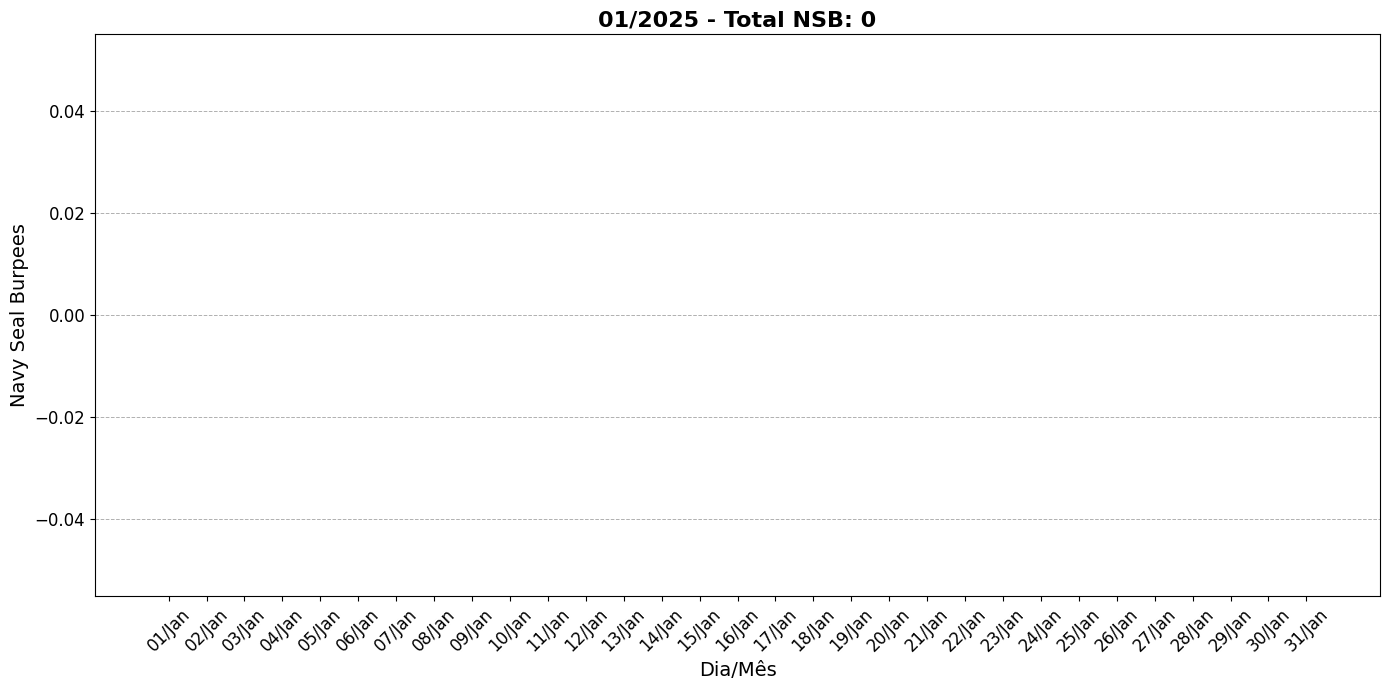

In [15]:
adicionar_dados_e_plotar(1, ano)

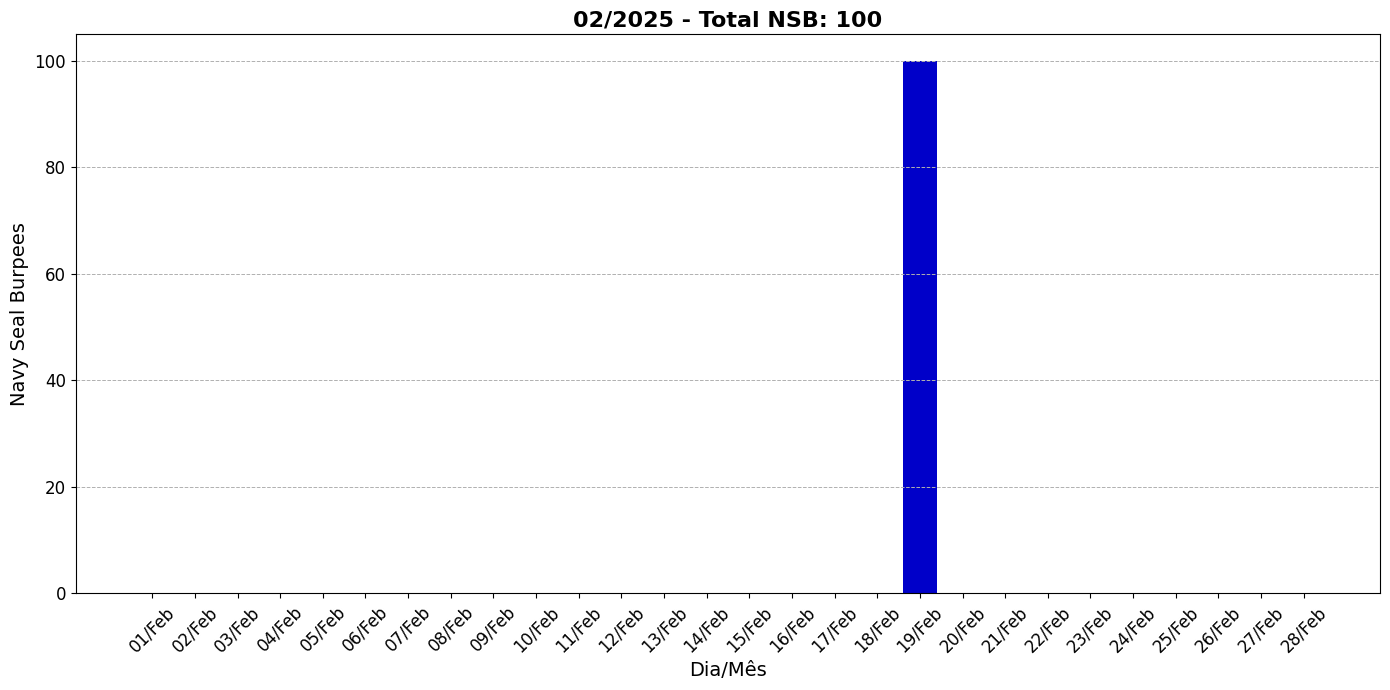

In [16]:
adicionar_dados_e_plotar(2, ano)

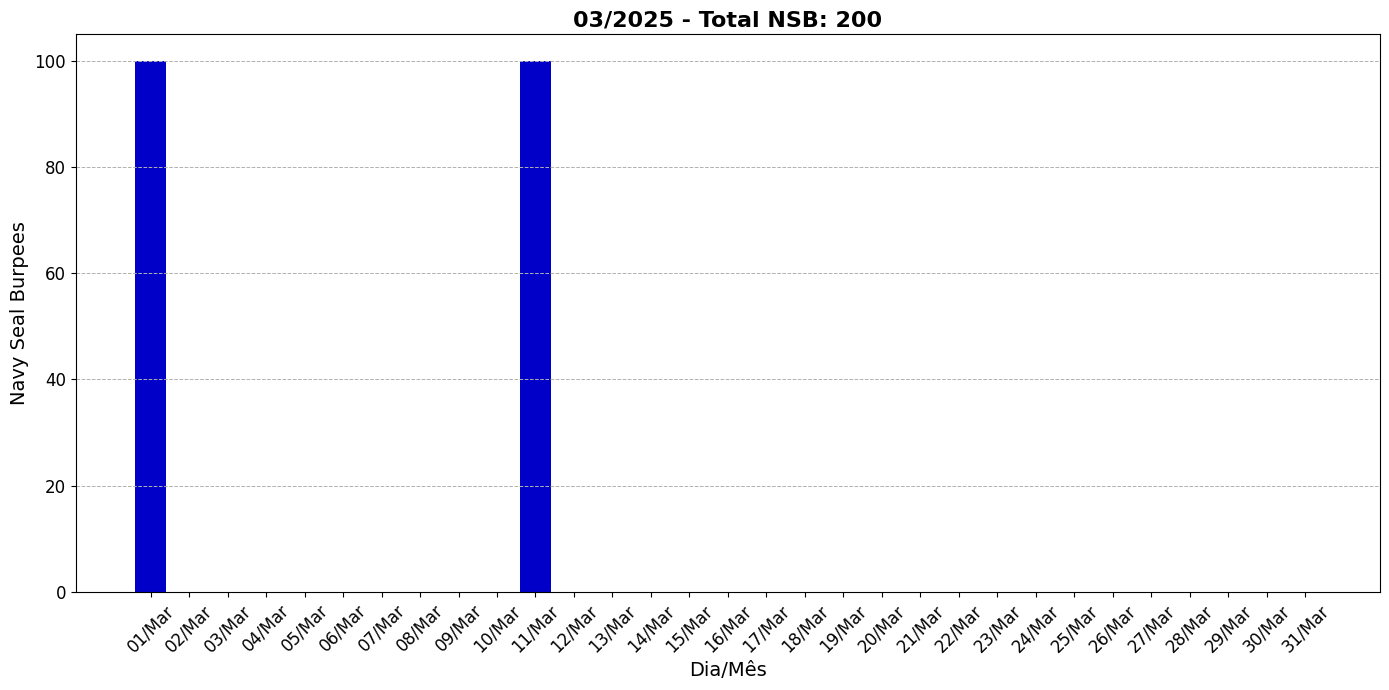

In [4]:
adicionar_dados_e_plotar(3, ano)

In [ ]:
adicionar_dados_e_plotar(4, ano) 

In [ ]:
adicionar_dados_e_plotar(5, ano) 

In [ ]:
adicionar_dados_e_plotar(6, ano) 

In [ ]:
adicionar_dados_e_plotar(7, ano) 

In [ ]:
adicionar_dados_e_plotar(8, ano) 

In [ ]:
adicionar_dados_e_plotar(9, ano) 

In [ ]:
adicionar_dados_e_plotar(10, ano)

In [ ]:
adicionar_dados_e_plotar(11, ano)

In [ ]:
adicionar_dados_e_plotar(12, ano)

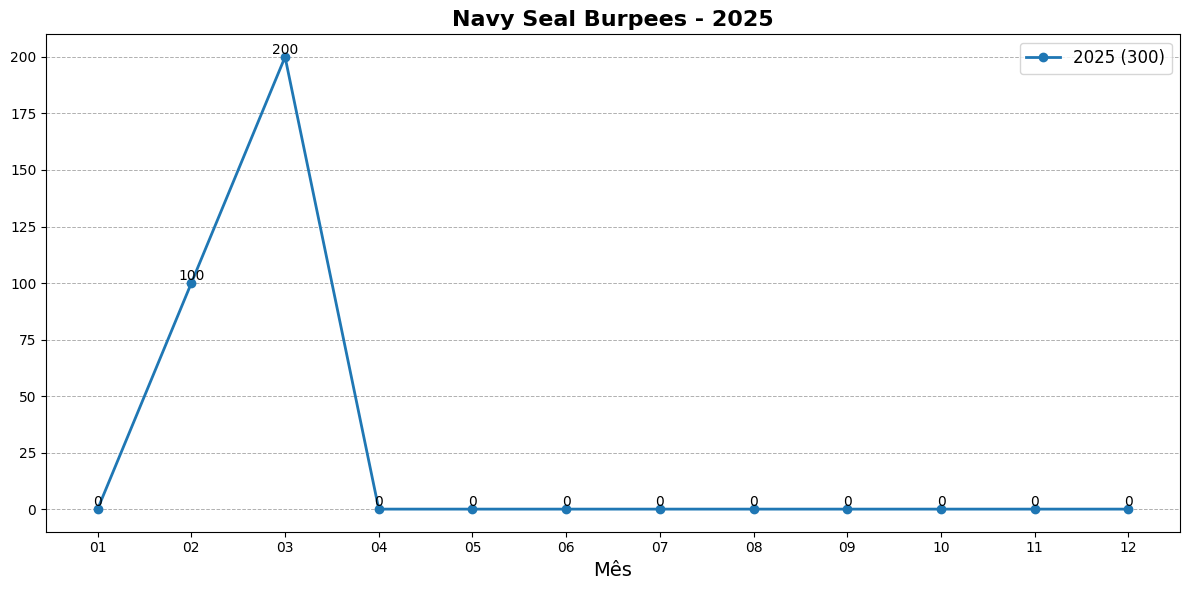

In [5]:
plotar_grafico_total(anos=[ano])

In [6]:
contar_frequencia(ano)

Quantidade   Frequência   Porcentagem 
0            362              99.18%
100          3               100.00%
